In [1]:
import numpy as np
import jax.numpy as jnp

import os
import sys
from pathlib import Path

module_path = str(Path(os.path.abspath('')).parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from functions.target_systems import *
from functions.RNCRN_tools import * 
from functions.RNCRN_train import * 
from functions.create_attractors_tools import * 
from functions.create_chimera_tools import * 
from functions.RNCRN_phase_plane import *
from functions.RNCRN_phase_line import * 

In [2]:
# create data for equilibrium target ODE
# sets intervals of executive species compact subsets (i.e. K_1)
lower_limit = 0.01
upper_limit = 3
step_size = 0.2

# sets the custom 2D equilibrium target ODE 
def target_dynamics_a(x, a):
    return a - x

# creates a meshgrid of values from the ODE
x12_train = np.arange(lower_limit, upper_limit + step_size, step_size )
xv1, xv2 = np.meshgrid(x12_train, x12_train, indexing='ij')

# converts training data into JAX format
inputs_a = jnp.array([xv1.flatten(),
                    xv2.flatten()])

targets_a = target_dynamics_a(inputs_a, 0)

In [3]:
# Invokes the code for Algorithm 1 (to generate limit cycle vector field)
# sets the parameter \delta
distance = 0.01

# sets the parameter \eta
magnitude = 1

# sets the parameter K (number of padding points)
number_of_padding_each_side = 20

# sets the interval of the variable that is used in the parametric equation to create a line of points 
low_parametric = 0
upper_parametric = 2*np.pi
step_parametric = 0.01

# calls a function that implements Algorithm 1 
parametric_circle = lambda x : parametric_concentric_circle(x, 1, 1.5)
inputs_b, targets_b = draw_attractor_parametric(parametric_circle, low_parametric, upper_parametric, step_parametric, distance, magnitude, number_of_padding_each_side)

In [4]:
# defines the number of parameter species
number_of_static_exec_species = 1

# defines map between parameter species value and target dynamics
static_exec_state_a = [0.1] # when r = 0.1 we want equilibrium dynamics
static_exec_state_b = [1] # when r = 1 we want limit cycle dynamics

# initialize training data for the parameter species 
exec_inputs_a = initialize_static_execs_data(number_of_static_exec_species, inputs_a, static_exec_state_a)
exec_inputs_b = initialize_static_execs_data(number_of_static_exec_species, inputs_b, static_exec_state_b)

In [5]:
# sets the hyper-structure of the RNCRN (i.e. N and M)   
number_of_exec_species = 2
number_of_chemical_perceptrons = 5

# calls a function that randomly initializes the RNCRN for training with automatic differentiation  
rnd_seed = 2
params = initialize_single_RNCRN_static_exec(number_of_exec_species, number_of_chemical_perceptrons, number_of_static_exec_species, rnd_seed)

In [6]:
# merges data into the correct format for training  
list_of_inputs = [inputs_a, inputs_b]
list_of_targets = [targets_a, targets_b]
list_of_exec_inputs = [exec_inputs_a, exec_inputs_b]

inputs, targets, exec_inputs = merge_static_execs_multi_state_data(list_of_inputs, list_of_targets, list_of_exec_inputs)

In [7]:
start_learning_rate = 5e1
batch_size = 500
error_threshold = 0.25 
number_of_epochs = 5000

loss, params, lowest_params, lowest_loss = train_static_executive_species(inputs, targets, exec_inputs, params, number_of_epochs, start_learning_rate, batch_size, error_threshold)

Epoch: 500 loss =  1.1296285
Lowest loss found!
Epoch: 1000 loss =  1.0768656
Lowest loss found!
Epoch: 1500 loss =  1.0603663
Lowest loss found!
Epoch: 2000 loss =  1.0569594
Lowest loss found!
Epoch: 2500 loss =  1.0554693
Lowest loss found!
Epoch: 3000 loss =  1.0535406
Lowest loss found!
Epoch: 3500 loss =  1.0492154
Lowest loss found!
Epoch: 4000 loss =  1.040291
Lowest loss found!
Epoch: 4500 loss =  1.0194526
Lowest loss found!


In [8]:
save_mat_model_static_exec(params, number_of_chemical_perceptrons, number_of_static_exec_species, number_of_exec_species, loss, rnd_seed, flag='app_toogle' )

In [9]:
# code to visualise quasi-static vector fields for validation
alpha_mat, omega_mat, bias_vec, beta_vec, gamma_vec, tau_vec, static_omega_mat = params
lower_limit = 0
inputs, data_shape = create_state_space_2D_array(lower_limit, upper_limit, step_size )
inputs_plot = array2D_to_meshgrid(inputs, data_shape)

quasi_static_vector_field_a = compute_quasi_static_vector_field_over_state_space_static_exec(inputs, np.array([[1]]), alpha_mat, omega_mat, bias_vec, beta_vec, gamma_vec, tau_vec, static_omega_mat)
quasi_static_vector_field_b = compute_quasi_static_vector_field_over_state_space_static_exec(inputs, np.array([[0.1]]), alpha_mat, omega_mat, bias_vec, beta_vec, gamma_vec, tau_vec, static_omega_mat)

Text(0, 0.5, 'State $x_2$')

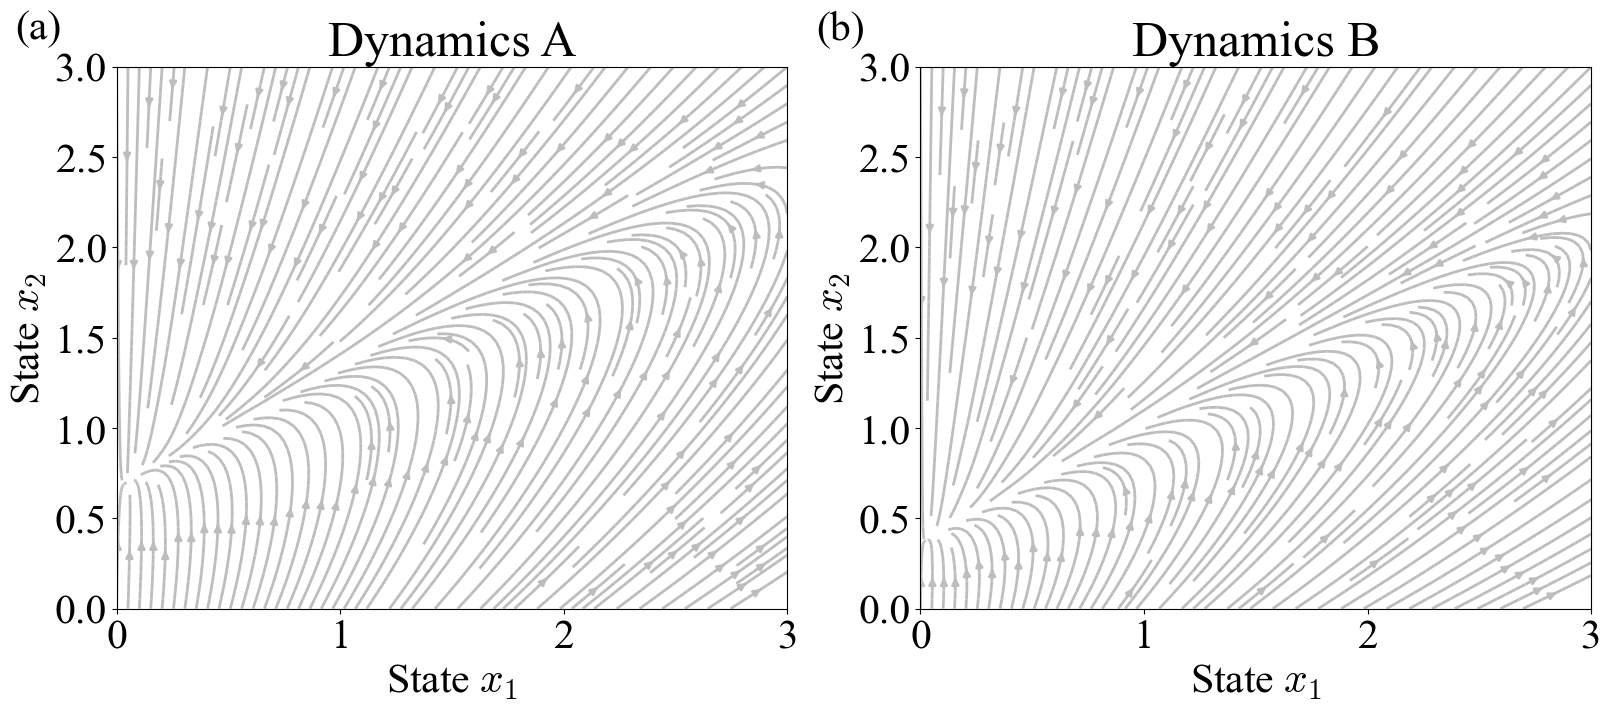

In [10]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
plt.rcParams['axes.prop_cycle'] = cycler(alpha=[1])
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']

mpl.rcParams['figure.figsize'] = [16, 7]

fig, axs = plt.subplot_mosaic([['(a)', '(b)']],  gridspec_kw={'width_ratios':[1,1]}, layout='constrained')


stablefp = 'limegreen'
linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  

density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', ha='right')

data_shape
axa = axs['(a)']
quasi_static_vector_field_plot = array2D_to_meshgrid(quasi_static_vector_field_a, data_shape)
axa.streamplot(np.transpose(inputs_plot[0,:,:]), np.transpose(inputs_plot[1,:,:]),
               np.transpose(quasi_static_vector_field_plot[0,:,:]), np.transpose(quasi_static_vector_field_plot[1,:,:]), 
               arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axa.set_xlim(lower_limit, upper_limit)
axa.set_ylim(lower_limit, upper_limit)
axa.set_title('Dynamics A')
axa.set_xlabel('State $x_1$')
axa.set_ylabel('State $x_2$')

axb = axs['(b)']
quasi_static_vector_field_plot = array2D_to_meshgrid(quasi_static_vector_field_b, data_shape)
axb.streamplot(np.transpose(inputs_plot[0,:,:]), np.transpose(inputs_plot[1,:,:]),
               np.transpose(quasi_static_vector_field_plot[0,:,:]), np.transpose(quasi_static_vector_field_plot[1,:,:]), 
               arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axb.set_xlim(lower_limit, upper_limit)
axb.set_ylim(lower_limit, upper_limit)
axb.set_title('Dynamics B')
axb.set_xlabel('State $x_1$')
axb.set_ylabel('State $x_2$')